# Interpret Results of Trained GCN
In this notebook, I'll try to visualize the learning of a trained GCN model. This should involve the following steps:
* Interpret the predictions made by the model
* Visualize the filters of the Graph Convolution
* Do a TSNE plot of the last layer

In [2]:
import numpy as np
import pandas as pd
#import my_gcn
import random, h5py
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from gcn.utils import *
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse import coo_matrix
import seaborn
import matplotlib.mlab as mlab

from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from sklearn.metrics import recall_score, precision_score

import sys, os
sys.path.append(os.path.abspath('../GCN'))
from my_gcn import MYGCN
import math
bestSplit = lambda x: (round(math.sqrt(x)), math.ceil(x / round(math.sqrt(x))))
%matplotlib inline

/home/sasse/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/sasse/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [33]:
model_dir = '../data/GCN/training/2018_02_14_12_12_53'
data_file = '../data/cancer/hotnet_iref_gcn_input_unbalanced.h5'
CLASSIFICATION_THRESHOLD = 0.5

with h5py.File(data_file, 'r') as f:
    network = f['network'][:]
    features = f['features'][:]
    node_names = f['gene_names'][:]
    y_train = f['y_train'][:]
    y_test = f['y_test'][:]
    if 'y_val' in f:
        y_val = f['y_val'][:]
    else:
        y_val = None
    train_mask = f['mask_train'][:]
    test_mask = f['mask_test'][:]
    if 'mask_val' in f:
        val_mask = f['mask_val'][:]
    else:
        val_mask = None

## Predictions
I want to see what the GCN predicts and if those predictions make any sense.

In [36]:
# load predictions
predictions = pd.DataFrame.from_csv(os.path.join(model_dir, 'predictions.tsv'), sep='\t', header=0)
features_df = pd.DataFrame(features, index=node_names[:, 0])
features_df['neighbors'] = network.sum(axis=0)
pred_with_feat = features_df.join(predictions, how='inner')
print (predictions.sum(axis=0))
pos_predicted = pred_with_feat[pred_with_feat.Prob_pos > CLASSIFICATION_THRESHOLD]

# add columns to distinguish between training and test set
labels_df = pd.DataFrame(node_names, index=node_names[:, 0], columns=['ID', 'Name']).drop(['ID', 'Name'], axis=1)
labels_df['positive'] = (y_train[:,0] | y_test[:,0])
labels_df['train_pos'] = y_train[:, 0]
labels_df['test_pos'] = y_test[:, 0]
labels_df['label'] = train_mask.astype(int)
labels_df['negative'] = labels_df.label & ~labels_df.positive

# show the ones that are most confidently predicted
print ("Predicted {} genes of {} total to be involved in infection".format(pos_predicted.shape[0], predictions.shape[0]))
pos_predicted.sort_values(by='Prob_pos', ascending=False).to_csv(os.path.join(model_dir, 'positive_prediction.txt'),
                                                                 sep='\t')
pos_predicted.sort_values(by='Prob_pos', ascending=False).head(20)

Name        A1BGA1CFA2MAAASAADATAAGABAAMPAANATAARSAARS2AAR...
Prob_pos                                             1068.552
dtype: object
Predicted 1036 genes of 12129 total to be involved in infection


,0,1,2,3,4,5,6,7,8,9,10,11,neighbors,Name,Prob_pos
CREBBP,10.920,11.460,10.640,10.660,11.350,11.080,12.160,11.140,11.100,11.630,10.870,11.160,224.000,CREBBP,1.000
NEDD4,8.720,8.900,8.100,8.320,9.180,9.440,9.490,8.230,8.600,6.540,8.140,6.360,111.000,NEDD4,1.000
SYK,9.640,9.270,10.910,9.160,10.520,9.760,12.290,10.330,10.400,10.660,10.800,10.320,75.000,SYK,1.000
BRCA1,8.860,8.440,8.770,8.380,8.930,6.990,10.280,7.940,8.560,7.370,8.730,8.040,177.000,BRCA1,1.000
HDAC5,10.130,10.200,9.760,10.280,10.300,10.340,10.650,10.230,10.040,10.190,10.080,10.260,79.000,HDAC5,1.000
HDAC3,10.130,9.970,10.190,10.290,10.300,10.030,9.660,10.040,10.260,9.890,10.240,9.850,148.000,HDAC3,1.000
MYB,6.050,10.170,10.390,3.730,5.710,2.700,12.720,6.560,7.110,7.790,10.240,7.720,63.000,MYB,1.000
MYC,10.650,10.670,12.450,9.730,12.070,10.610,11.450,10.260,11.440,11.590,12.790,9.580,271.000,MYC,1.000
SMARCC1,11.830,11.840,11.690,10.590,11.360,10.580,12.080,11.300,11.390,11.810,11.790,11.720,67.000,SMARCC1,1.000
HDAC2,11.250,11.140,11.240,10.690,11.050,10.430,10.980,10.850,11.430,11.190,11.090,11.280,213.000,HDAC2,1.000


In [40]:
predictions[predictions.index == 'KRAS']

,Name,Prob_pos
ID,,
KRAS,KRAS,0.998


Correlation of prediction with #neighbors: 0.42976029887423745
Correlation of prediction with #neighbors for positives: 0.3174498531770127


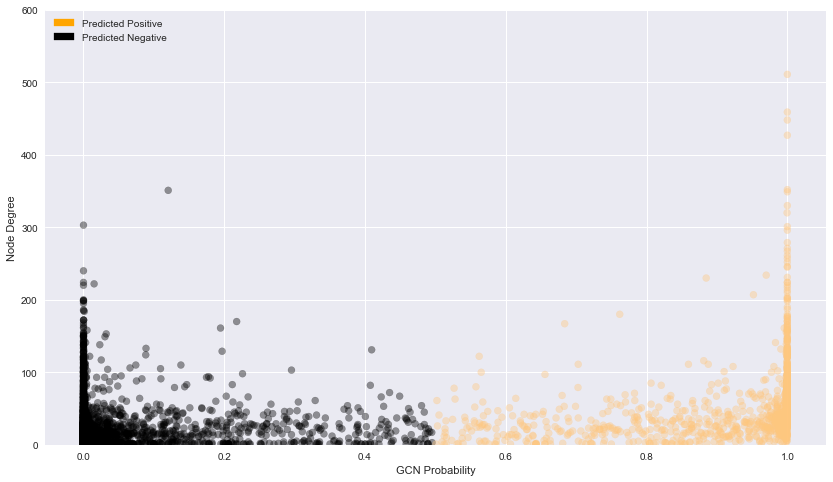

In [38]:
pagerank_scores = pd.DataFrame.from_csv('../data/cancer/pagerank_scores_hotnet_iref.txt', sep='\t')
df = pagerank_scores.join(pred_with_feat, how='inner')
ranks = df.rank(axis=0)

fig = plt.figure(figsize=(14, 8))
plt.scatter(df.Prob_pos, df.neighbors, c=df.Prob_pos >= CLASSIFICATION_THRESHOLD, cmap=plt.cm.copper, alpha=0.4)
plt.gca().set_ylim([0, 600])
plt.xlabel('GCN Probability')
plt.ylabel('Node Degree')
pred = mpatches.Patch(color='orange', label='Predicted Positive')
non_pred = mpatches.Patch(color='black', label='Predicted Negative')
plt.legend(handles=[pred, non_pred], loc='upper left')
fig.savefig(os.path.join(model_dir, 'degree_correlation.png'))

df_pos = df[df.Prob_pos >= CLASSIFICATION_THRESHOLD]
print ("Correlation of prediction with #neighbors: {}".format(df.Prob_pos.corr(df.neighbors)))
print ("Correlation of prediction with #neighbors for positives: {}".format(df_pos.Prob_pos.corr(df_pos.neighbors)))

In [39]:
labels_with_pred = labels_df.join(predictions)
predictions_for_pos = labels_with_pred[labels_with_pred.positive == 1]
true_positives = predictions_for_pos[predictions_for_pos.Prob_pos > CLASSIFICATION_THRESHOLD]
no_tp = true_positives.shape[0]
no_positives = predictions_for_pos.shape[0]
pred_pos_test = true_positives[true_positives.test_pos == 1]
pred_pos_train = true_positives[true_positives.train_pos == 1]
predictions_for_neg = labels_with_pred[labels_with_pred.negative == 1]
true_negatives = predictions_for_neg[predictions_for_neg.Prob_pos <= CLASSIFICATION_THRESHOLD]
no_tn = true_negatives.shape[0]
no_fn = predictions_for_neg[predictions_for_neg.Prob_pos > CLASSIFICATION_THRESHOLD].shape[0]
print ("Predicted {} out of {} known infection genes".format(no_tp, no_positives)
      )
print ("Out of these {}, {} were not shown during training.".format(no_positives,
                                                                    y_test[:, 0].sum())
      )
print ("Predicted {} out of {} test genes ({}%)".format(pred_pos_test.shape[0],
                                                        y_test[:,0].sum(),
                                                        pred_pos_test.shape[0]/y_test[:,0].sum()*100.)
      )
print ("Predicted {} out of {} train genes ({}%)".format(pred_pos_train.shape[0],
                                                         y_train[:,0].sum(),
                                                         pred_pos_train.shape[0]/y_train[:,0].sum()*100.)
      )
print ("Correctly rejected {} out of {} true negatives ({}%)".format(no_tn,
                                                                     predictions_for_neg.shape[0],
                                                                     no_tn/predictions_for_neg.shape[0]*100.))
print ("Falsely rejected {} negatives (FN)".format(no_fn))
predictions_for_pos.sort_values(by='Prob_pos', ascending=False).head(100)

Predicted 84 out of 123 known infection genes
Out of these 123, 49 were not shown during training.
Predicted 21 out of 49 test genes (42.857142857142854%)
Predicted 63 out of 74 train genes (85.13513513513513%)
Correctly rejected 1306 out of 1354 true negatives (96.4549483013294%)
Falsely rejected 48 negatives (FN)


,positive,train_pos,test_pos,label,negative,Name,Prob_pos
ABL1,1,1,0,1,0,ABL1,1.000
BRCA1,1,1,0,1,0,BRCA1,1.000
JAK2,1,0,1,0,0,JAK2,1.000
PIK3R1,1,1,0,1,0,PIK3R1,1.000
PTPN11,1,1,0,1,0,PTPN11,1.000
RB1,1,0,1,0,0,RB1,1.000
SMAD2,1,1,0,1,0,SMAD2,1.000
SMAD4,1,1,0,1,0,SMAD4,1.000
ERBB2,1,1,0,1,0,ERBB2,1.000
CTNNB1,1,1,0,1,0,CTNNB1,1.000


ACCURACY: 0.9897765685547036


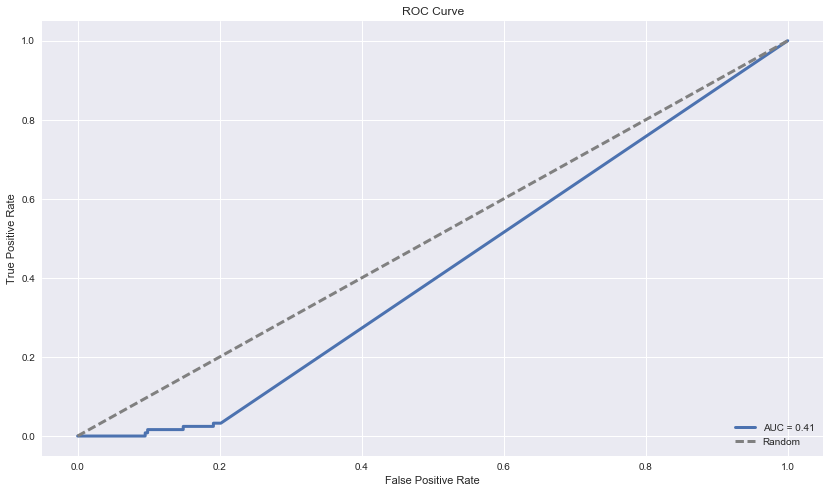

In [32]:
y = np.logical_or(y_train, y_test)
fpr, tpr, thresholds = roc_curve(y[:, 0], predictions.Prob_pos)
roc_auc = roc_auc_score(y[:, 0], predictions.Prob_pos)
fig = plt.figure(figsize=(14, 8))
plt.plot(fpr, tpr, lw=3, label='AUC = {0:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', lw=3, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
fig.savefig(model_dir + 'roc_curve.png')
acc = accuracy_score(y_true=y, y_pred=predictions.Prob_pos >= CLASSIFICATION_THRESHOLD)
print ("ACCURACY: {}".format(acc))

Precision: 0.08108108108108109	Recall: 0.6829268292682927


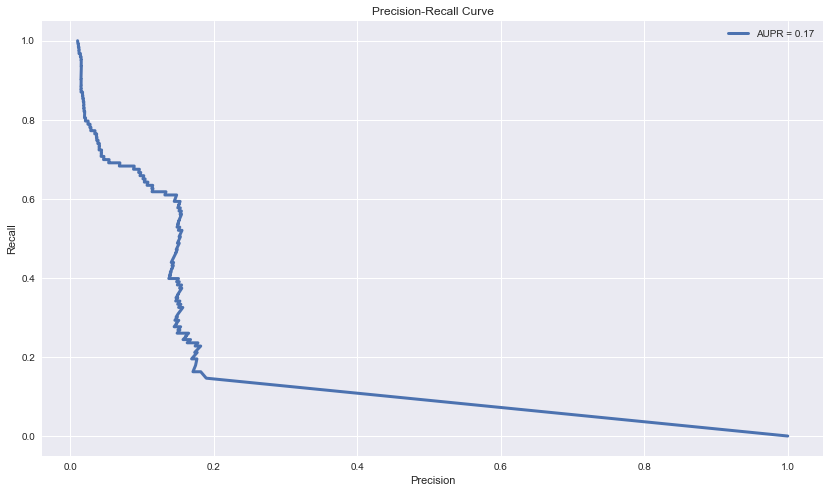

In [26]:
pr, rec, thresholds = precision_recall_curve(y[:, 0], predictions.Prob_pos)
aupr = average_precision_score(y[:,0], predictions.Prob_pos)
fig = plt.figure(figsize=(14, 8))
plt.plot(pr, rec, lw=3, label='AUPR = {0:.2f}'.format(aupr))
#plt.plot([0, 1], [0, 1], color='gray', lw=3, linestyle='--')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve')
plt.legend()
fig.savefig(model_dir + 'prec_recall.png')
recall = recall_score(y_true=y, y_pred=predictions.Prob_pos >= CLASSIFICATION_THRESHOLD)
precision = precision_score(y_true=y, y_pred=predictions.Prob_pos >= CLASSIFICATION_THRESHOLD)
print ("Precision: {}\tRecall: {}".format(precision, recall))

## Investigate New Model GCN Parameters

In [25]:
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
checkpoint_path = os.path.join(model_dir, "model.ckpt")
#print_tensors_in_checkpoint_file(file_name=checkpoint_path, tensor_name='', all_tensors=True)


In [26]:
def str_to_num(s):
    try:
        return int(s)
    except ValueError:
        return float(s)

def load_hyper_params(model_dir):
    file_name = os.path.join(model_dir, 'hyper_params.txt')
    with open(file_name, 'r') as f:
        args = {}
        for line in f.readlines():
            key, value = line.split('\t')
            args[key.strip()] = str_to_num(value.strip())
    print ("Hyper-Parameters read from {}".format(file_name))
    return args

args = load_hyper_params(model_dir)
args

Hyper-Parameters read from ../data/GCN/training/2018_02_13_18_09_48/hyper_params.txt


{'decay': 0.0005,
 'dropout': 0.1,
 'epochs': 5000,
 'hidden1': 20,
 'hidden2': 50,
 'loss_mul': 175.0,
 'lr': 0.01,
 'support': 2}

In [27]:
tf.reset_default_graph()
adj = csr_matrix(network)
F = lil_matrix(features)
F = preprocess_features(F)

poly_support = args['support']
if poly_support > 1:
    support = chebyshev_polynomials(adj, poly_support)
    num_supports = 1 + poly_support
else:
    support = [preprocess_adj(adj)]
    num_supports = 1
print (len(support))
print ([s[2] for s in support])

placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32,
                                      shape=tf.constant(features.shape, dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

def predict(features, support, labels, mask, placeholders):
    feed_dict_pred = construct_feed_dict(features, support, labels, mask, placeholders)
    pred = sess.run(model.predict(), feed_dict=feed_dict_pred)
    return pred

ckpt = tf.train.get_checkpoint_state(checkpoint_dir=model_dir)
ckpt.model_checkpoint_path

if ckpt and ckpt.model_checkpoint_path:
    with tf.Session() as sess:
        model = MYGCN(placeholders,
                      input_dim=features.shape[1],
                      learning_rate=args['lr'],
                      num_hidden1=args['hidden1'],
                      num_hidden2=args['hidden2'],
                      pos_loss_multiplier=args['loss_mul'],
                      weight_decay=args['decay'],
                      logging=True)
        model.load(checkpoint_path, sess)
        print ("loaded")
        weight_matrices = []
        for var in model.vars: # chebychev coefficients
            weight_matrices.append(model.vars[var].eval(session=sess))

        # predict for test set and catch activations in H_1, H_2
        feed_dict = construct_feed_dict(features=F,
                                        support=support,
                                        labels=y_train,
                                        labels_mask=train_mask,
                                        placeholders=placeholders
                                       )
        #l = sess.run(model.loss, feed_dict=feed_dict)
        activations = []
        for layer_act in model.activations:
            activation = sess.run(layer_act, feed_dict=feed_dict)
            activations.append(activation)

len(activations), len(weight_matrices)

/home/sasse/.local/lib/python3.6/site-packages/gcn-1.0-py3.6.egg/gcn/utils.py:97: RuntimeWarning: divide by zero encountered in power


Calculating Chebyshev polynomials up to order 2...
3
[(12129, 12129), (12129, 12129), (12129, 12129)]
INFO:tensorflow:Restoring parameters from ../data/GCN/training/2018_02_13_18_09_48/model.ckpt
loaded


(4, 9)

In [28]:
preds_and_labels = labels_df.join(predictions)
pos_classified = preds_and_labels.Prob_pos >= CLASSIFICATION_THRESHOLD

# set the colors according to classes
preds_and_labels['color'] = 'gray'
preds_and_labels.loc[pos_classified, 'color'] = 'red'
preds_and_labels.loc[~preds_and_labels.label & pos_classified, 'color'] = 'green'
preds_and_labels.groupby('color').count()

,positive,train_pos,test_pos,label,negative,Name,Prob_pos
color,,,,,,,
gray,11300,11300,11300,11300,11300,11300,11300
green,743,743,743,743,743,743,743
red,86,86,86,86,86,86,86


Plotted TSNE for activation in layer 1 successfully
Plotted TSNE for activation in layer 2 successfully
Plotted TSNE for activation in layer 3 successfully
Plotted TSNE for activation in layer 4 successfully


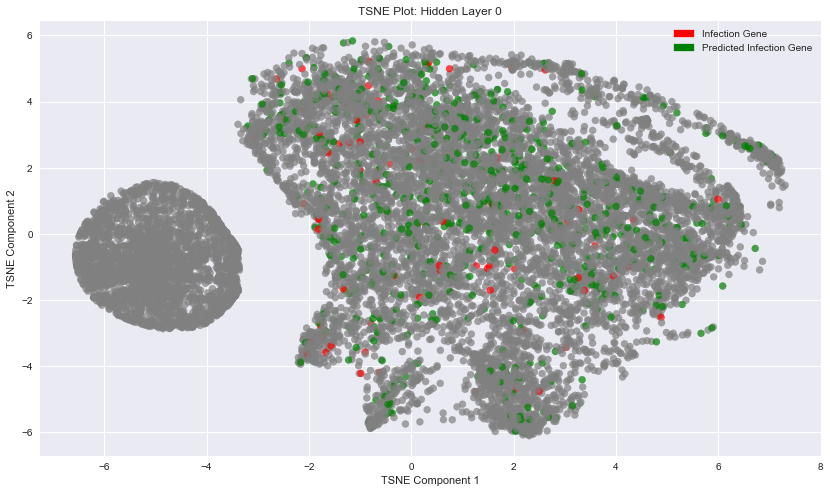

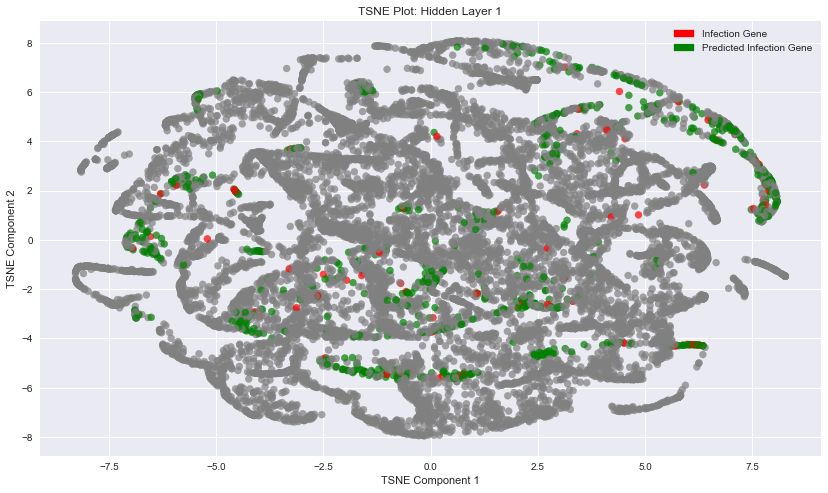

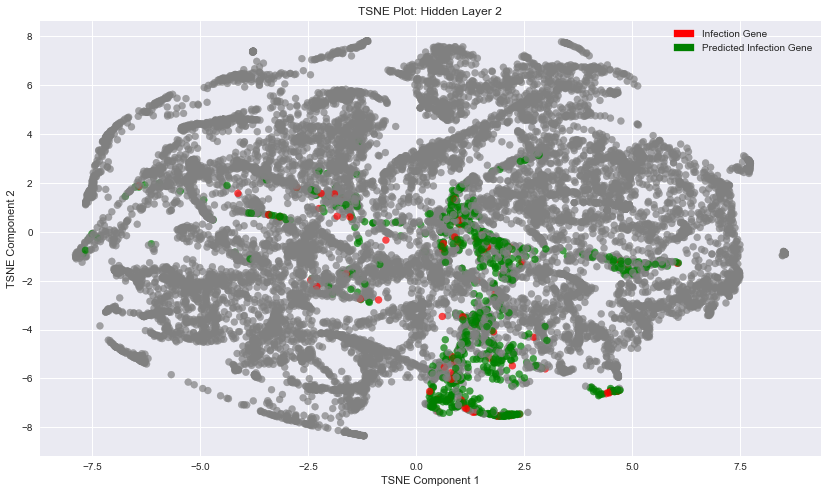

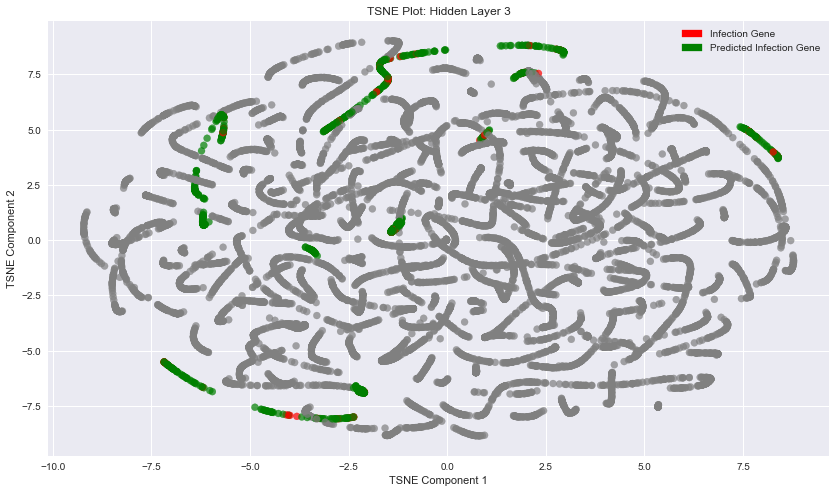

In [29]:
layer_num = 0
embeddings = []
for act in activations:
    if layer_num == 0:
        input_data = coo_matrix((act.values,
                                (act.indices[:, 0], act.indices[:, 1])),
                                shape=act.dense_shape)
        embedding = TSNE(n_components=2).fit_transform(input_data.todense())
    else:
        embedding = TSNE(n_components=2).fit_transform(act)
    embeddings.append(embedding)
    fig = plt.figure(figsize=(14, 8))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=preds_and_labels.color, alpha=0.7)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.title('TSNE Plot: Hidden Layer {}'.format(layer_num))

    # legend
    inf_genes = mpatches.Patch(color='red', label='Infection Gene')
    pred_genes = mpatches.Patch(color='green', label='Predicted Infection Gene')
    not_involved = mpatches.Patch(color='gray', label='Not Involved in Infection')
    plt.legend(handles=[inf_genes, pred_genes])

    # save
    fig.savefig(model_dir + '/tsne_{}.png'.format(layer_num), dpi=300)
    layer_num += 1
    print ("Plotted TSNE for activation in layer {} successfully".format(layer_num))

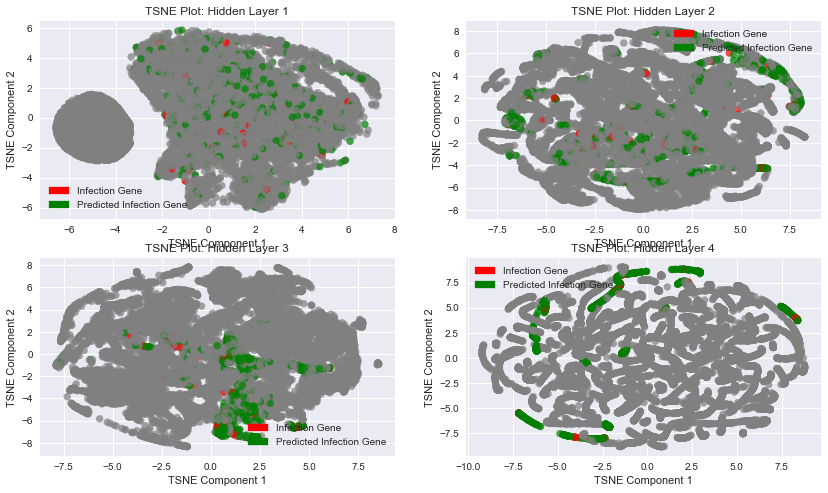

In [30]:
# one plot for all the TSNEs
fig = plt.figure(figsize=(14, 8))
x, y = bestSplit(len(embeddings))
count = 1
for embedding in embeddings:
    plt.subplot(x, y, count)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=preds_and_labels.color, alpha=0.7)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.title('TSNE Plot: Hidden Layer {}'.format(count))

    # legend
    inf_genes = mpatches.Patch(color='red', label='Infection Gene')
    pred_genes = mpatches.Patch(color='green', label='Predicted Infection Gene')
    not_involved = mpatches.Patch(color='gray', label='Not Involved in Infection')
    plt.legend(handles=[inf_genes, pred_genes])
    count += 1
fig.savefig('TSNE_all_layers.png', dpi=200)

## Do the predictions have special properties?
I want to check the shortest path between predicted disease genes and true disease genes as well.
Further, I want to see them in a network.

In [11]:
# build networkx graph with correct node names
G = nx.from_numpy_matrix(network)
#mapping = {i:node_names[i, 0] for i in range(node_names.shape[0])}
#nx.relabel_nodes(G, mapping, copy=False)

### Shortest Paths

In [331]:
# calculate shortest paths between all nodes and make it a dataframe matrix
all_shortest_paths = nx.shortest_path_length(G)
sp_df = pd.DataFrame(dict(all_shortest_paths))

In [358]:
sp_df['name'] = node_names[:, 0]

(2386, 12130)

In [359]:
# build views for label to label shortest paths and non-label to non-label
label_cond = sp_df.name.isin(pos_predicted.index)
sp_df.drop('name', axis=1, inplace=True)
label_to_label = sp_df.loc[label_cond, label_cond]
nonlabel_to_nonlabel = sp_df.loc[~label_cond, ~label_cond]
label_to_nonlabel = sp_df.loc[~label_cond, label_cond]

(5692996,) (94926049,) (23246798,)


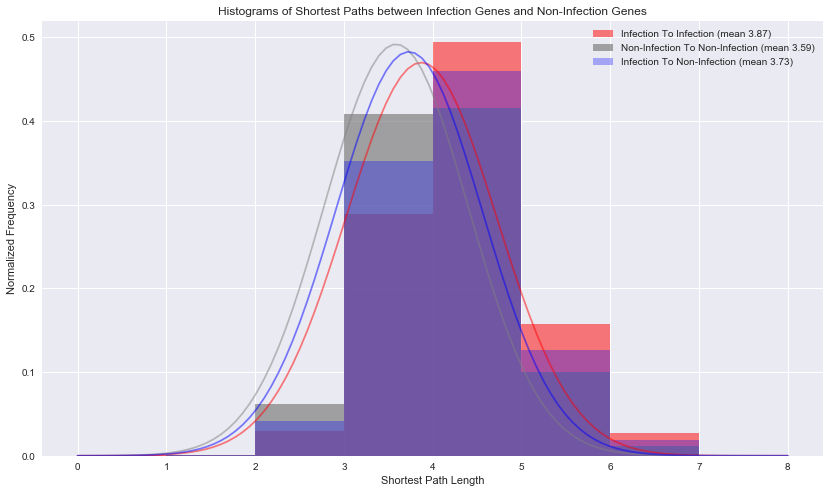

In [361]:
# plot the distributions
fig = plt.figure(figsize=(14, 8))
bins = np.arange(0, 8, 1)

ltl = pd.Series(label_to_label.values.flatten()).dropna()
ntn = pd.Series(nonlabel_to_nonlabel.values.flatten()).dropna()
ltn = pd.Series(label_to_nonlabel.values.flatten()).dropna()
print (ltl.shape, ntn.shape, ltn.shape)
plt.hist(ltl, bins=bins, alpha=.5, normed=True, color='red',
         label='Infection To Infection (mean {0:.2f})'.format(ltl.mean()))
plt.hist(ntn, bins=bins, alpha=.7, normed=True, color='gray',
         label='Non-Infection To Non-Infection (mean {0:.2f})'.format(ntn.mean()))
plt.hist(ltn, bins=bins, alpha=.3, normed=True, color='blue',
         label='Infection To Non-Infection (mean {0:.2f})'.format(ltn.mean()))
points = np.linspace(0, 8, 100)
plt.plot(points, mlab.normpdf(points, ltl.mean(), ltl.std()), color='red', alpha=0.5)
plt.plot(points, mlab.normpdf(points, ntn.mean(), ntn.std()), color='gray', alpha=0.5)
plt.plot(points, mlab.normpdf(points, ltn.mean(), ltn.std()), color='blue', alpha=0.5)
plt.legend()
plt.title('Histograms of Shortest Paths between Infection Genes and Non-Infection Genes')
plt.xlabel('Shortest Path Length')
plt.ylabel('Normalized Frequency')
fig.savefig(os.path.join(model_dir, 'path_length_distribution.png'))

### Node Degree

In [12]:
degree_df = pd.Series(dict(all_node_degrees))
degree_df = pd.DataFrame(degree_df, index=node_names[:, 0])
degree_df.isnull().sum()

NameError: name 'all_node_degrees' is not defined

In [364]:
# calculate shortest paths between all nodes and make it a dataframe matrix
all_node_degrees = G.degree()
degree_df = pd.Series(dict(all_node_degrees))

degree_df['name'] = node_names[:, 0]

# build views for label and non-label degrees
label_cond = degree_df.name.isin(pos_predicted.index)
labels = degree_df[label_cond]
nonlabels = degree_df[~label_cond]
print (labels.shape, nonlabels.shape)

# plot histograms
fig = plt.figure(figsize=(14, 8))
bins = np.arange(0, 50, 1)
plt.hist(labels, bins=bins, alpha=.5, normed=True, color='red',
         label='Infection Genes (Median {})'.format(labels.median()))
plt.hist(nonlabels, bins=bins, alpha=.7, normed=True, color='gray',
         label='Other Genes (Median {})'.format(nonlabels.median()))
plt.legend()
plt.title('Histograms of Node Degree for Infection and Other Genes')
plt.xlabel('Node Degree')
plt.ylabel('Normalized Frequency')
fig.savefig(os.path.join(model_dir, 'node_degrees.png'))

AttributeError: 'NoneType' object has no attribute 'isin'

### Probability that Neighbor of Infection Gene is also Infection Gene

In [ ]:
# half because of symmetric matrix
num_of_neighbor_labels = label_to_label[label_to_label == 1].count().sum() / 2
prob_neighbor_label = (num_of_neighbor_labels / label_to_label.shape[0]) * 100
print ("Chance of label to have labeled neighbor: {0:.2f} %".format(prob_neighbor_label))

In [ ]:
num_label_nbs = []
num_nbs = []
for label in predictions.index:
    nbs = list(nx.all_neighbors(G, label))
    label_nbs = predictions_for_knowns.index.isin(nbs).sum()
    num_label_nbs.append(label_nbs)
    num_nbs.append(len(nbs))
num_label_nbs = np.array(num_label_nbs)
num_total_nbs = np.array(num_nbs)
print ("Number of labeled neighbors: {}".format(num_label_nbs.sum()))
print ("Number of neighbors total: {}".format(num_total_nbs.sum()))
freq = num_label_nbs.sum()/num_total_nbs.sum()
print ("Chance that neighbor is labeled: {0:.4f}".format(freq))

(array([3533.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        8596.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

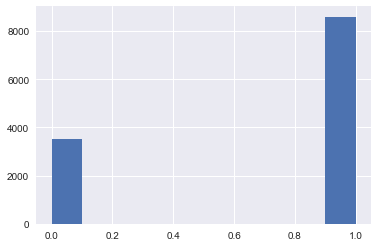

In [296]:
plt.hist(np_input)

In [297]:
rowsum = features.sum(1)
r_inv = np.power(rowsum, -1).flatten()
r_inv[np.isinf(r_inv)] = 0.
r_mat_inv = np.diag(r_inv)
f2 = r_mat_inv.dot(features)

/pkg/python-3.6.0-0/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in power
  from ipykernel import kernelapp as app


## Correlation with other methods
I will now try to see how similar my performance is to NetRank and PageRank.

In [ ]:
netrank_scores = pd.DataFrame.from_csv('../data/pagerank/netrank_scores.txt', header=0, sep='\t')
netrank_scores.rename(columns={'Rank': 'NetRank_Rank'})
predictions.sort_values('Prob_pos', ascending=False, inplace=True)
predictions['GCN_Rank'] = np.arange(1, predictions.shape[0]+1)
print ("Correlation Rank & Prob: {}".format(predictions.Prob_pos.corr(predictions.GCN_Rank)))

In [ ]:
netrank_with_predictions = predictions.join(netrank_scores, how='inner')
fig = plt.figure(figsize=(14, 14))
plt.scatter(netrank_with_predictions.GCN_Rank, netrank_with_predictions.Rank, color='gray')
lin = np.arange(1, netrank_with_predictions.shape[0]+1)
plt.plot(lin, lin, '--', color='black')

print ("Correlation between NetRank and GCN: {}".format(netrank_with_predictions.Rank.corr(netrank_with_predictions.GCN_Rank)))

In [ ]:
netrank_scores.head()